In [1]:
import sys

sys.path.append('..')
sys.path.append('../inference')
sys.path.append('../data')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ai_trainer import Personal_Trainer
import squat_separation as ss
import os

%matplotlib inline

#Step 1: Get Squats

In [2]:
#=====[ Parses a text file into an array of coords ]=====
data = []
with open(os.path.join('../data/raw_data/squat_pushupData_10to20/','squatData15.txt')) as f:
    for line in f:
        data.append([float(x.replace('\r\n','')) for x in line.split(',')])
        

In [3]:
#=====[ Instantiate Personal Trainer with the key we want to use as our indicator for rep separation ]=====
pt = Personal_Trainer({'squat':'NeckY'})

#Use the line immediately below for data pulle drom text files and parsed in the function above. Label is specified manually
squats = pt.analyze_reps('../data/raw_data/squat_pushupData_10to20/squatData17.txt','squat')
# pt.load_reps('squats10.p')
# squats = pt.get_reps()

# Use the line immediately below for data pulled directly from a .py file (array of coords + label)
# squats = pt.analyze_reps(cd3.data,cd3.label)

[SUCCESS] ---------- > Reps segmented and normalized


#Step 2: Extract Features

##V1 Features:

4 Frames

- All coordinates of starting position
- All coordintes halfway between starting and squat position
- All coordinates in squat position
- All coordinates halfway between squat position and ending position

In [4]:
#======[ Returns index to frame with minimum y-coord for specified key ]=====
def get_min(squat,key):   
    
    #=====[ Return max because of inverse frame of reference of kinect ]=====
    return max([(coord,index) for index, coord in enumerate(squat[key])])[1]

In [5]:
#=====[ Returns index to frame with y-coord closes to the midpoint between start/end and squat position for specified key ]=====
def get_midpoint(squat,start,key):
    
    #=====[ Decide whether getting midpoint between start and squat or squat and end ]=====
    if start:
        start = 1
        end = get_min(squat,key)
    else:
        start = get_min(squat,key)
        end = squat.shape[0] - 1
        
    true_mid = (squat.iloc[end][key] - squat.iloc[start][key])/2
    deltas = [(np.abs(true_mid - (squat.iloc[end][key] - squat.iloc[index][key])), index) for index in range(start,end)]
    return min(deltas)[1]

In [6]:
#=====[ Returns squat at the first position ]=====
def starting_position(squat):
    return squat.iloc[[1]]

In [7]:
#=====[ Returns index to frame with y-coord closes to the midpoint between start and squat position for specified key ]=====
def start_to_squat(squat,key):
    return squat.iloc[[get_midpoint(squat,start=1,key=key)]]

In [8]:
#=====[ Returns frame with minimum y-coord for specified key ]=====
def squat_position(squat,key):
    return squat.iloc[[get_min(squat,key)]]

In [9]:
#=====[ Returns index to frame with y-coord closes to the midpoint between squat position and end for specified key ]=====
def squat_to_end(squat,key):
    return squat.iloc[[get_midpoint(squat,start=0,key=key)]]

#Sample Extracted Frames

In [15]:
#=====[ function for plotting full set of 25 coordinates for a given frame ]=====
def plotBody(df):
    coords = np.array(df)
    
    xs = [coords[0][i] for i in range(0,coords.size) if i % 3 == 0]
    #=====[ Plot -1* coords because of kinect's frame of reference ]=====
    ys = [-1*coords[0][i] for i in range(0,coords.size) if i % 3 == 1]

    plt.plot(xs,ys,linestyle='None',marker='o')
    plt.axis([-0.6,0.6,-1.2,0.2])


##Initial State

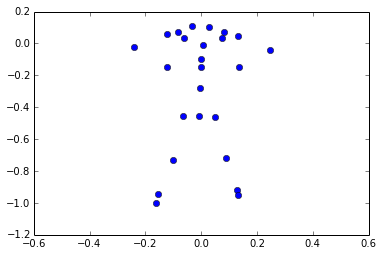

In [16]:
fset1 = np.array(starting_position(squats[0]))
plotBody(fset1)

##In between start and squat position

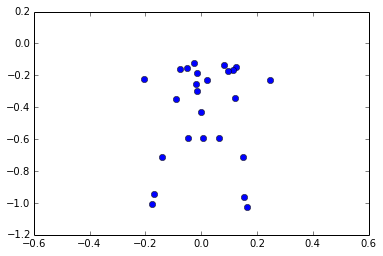

In [19]:
fset2 = start_to_squat(squats[0],'NeckY')
plotBody(fset2)

##In squat position

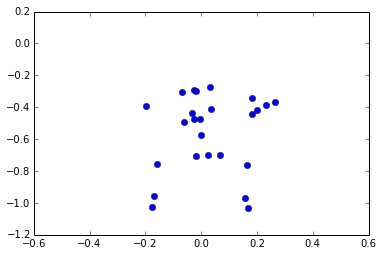

In [20]:
fset3 = np.array(squat_position(squats[0],'NeckY'))
plotBody(fset3)

##Going from squat to end

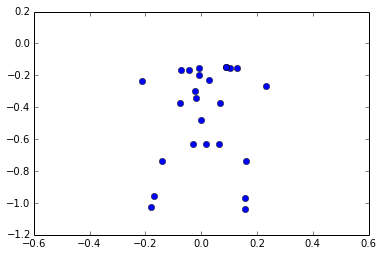

In [21]:
fset4 = np.array(squat_to_end(squats[0],'NeckY'))
plotBody(fset4)

#Step 3: Combine frames to make feature vector

In [22]:
feature_vector = np.concatenate([fset1,fset2,fset3,fset4],axis=1)
print feature_vector.shape

(1, 300)
